# CASTER Example

![CASTER](https://github.com/krondor/HCLSWorkshopDS/blob/master/CASTERflow.png?raw=true)

## Prerequisite Library Installation

In [38]:
!pip install subword-nmt torch torchvision

## Imports

In [14]:
import os

import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch import nn 
import copy

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.model_selection import KFold
torch.manual_seed(2)    # reproducible torch:2 np:3
np.random.seed(3)

#from dde_config import dde_NN_config
#from dde_torch import dde_NN_Large_Predictor
#from stream_dde import supData, unsupData

from zipfile import ZipFile

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [34]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_01da3b8d07aa40ca85ec5cee0637167f = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='1Ba7JkqCTf1OZi9NzfLuRpA-NBjduZf7RnqXt5_EF0pq',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_1 = client_01da3b8d07aa40ca85ec5cee0637167f.get_object(Bucket='healthcare-donotdelete-pr-g9fwkdix0hpnfd', Key='DDE.zip')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(streaming_body_1, "__iter__"): streaming_body_1.__iter__ = types.MethodType( __iter__, streaming_body_1 ) 


In [16]:

body = client_01da3b8d07aa40ca85ec5cee0637167f.get_object(Bucket='healthcare-donotdelete-pr-g9fwkdix0hpnfd',Key='unsup_dataset.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()


index                                                  0  \
0  202274  CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)(O)OCC...   
1  381808             Cc1ncc2n1-c1ccc(Cl)cc1C(c1ccccc1F)=NC2   
2  372979            O=c1oc2ccccc2c(O)c1Cc1c(O)c2ccccc2oc1=O   
3   60778        COc1c(OC)c(O)c2c(=O)cc(-c3ccc(O)cc3)oc2c1OC   
4  196908                                COC(OC)C(C)c1ccccc1   

                                                   1        2  
0  CC(O)=N[C@@H]1[C@@H](O)C=C(C(=O)O)O[C@H]1[C@H]...  df_pair  
1                 CNCCC(Oc1ccc(C(F)(F)F)cc1)c1ccccc1  dd_pair  
2  C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2cc...  dd_pair  
3  CCC1=C[C@@H]2CN(C1)Cc1c([nH]c3ccccc13)[C@@](C(...  df_pair  
4                    CN(C)c1cccc2c(S(=O)(=O)O)cccc12  df_pair

In [35]:
from io import BytesIO

with BytesIO(streaming_body_1.read()) as tf:

    # rewind the file
    tf.seek(0)

    # Read the file as a zipfile and process the members
    with ZipFile(tf, mode='r') as zipf:
        zipf.extractall()

In [40]:
os.chdir('./DDE')

from dde_config import dde_NN_config
from dde_torch import dde_NN_Large_Predictor
from stream_dde import supData, unsupData

## Functions

In [41]:
def test_dde_nn(data_generator, model_nn):
    y_pred = []
    y_label = []
    model_nn.eval()
    for i, (v_D, label) in enumerate(data_generator):
        recon, code, score, Z_f, z_D = model_nn(v_D.float().cuda())
        m = torch.nn.Sigmoid()
        logits = torch.squeeze(m(score)).detach().cpu().numpy()
        label_ids = label.to('cpu').numpy()
        y_label = y_label + label_ids.flatten().tolist()
        y_pred = y_pred + logits.flatten().tolist()

    return roc_auc_score(y_label, y_pred), y_pred


def main_dde_nn():
    config = dde_NN_config()
    pretrain_epoch = config['pretrain_epoch']
    pretrain_epoch = 0
    train_epoch = 9
    lr = config['LR']
    thr = config['recon_threshold']
    recon_loss_coeff = config['reconstruction_coefficient']
    proj_coeff = config['projection_coefficient']
    lambda1 = config['lambda1']
    lambda2 = config['lambda2']
    BATCH_SIZE = config['batch_size']
    
    loss_r_history = []
    loss_p_history = []
    loss_c_history = []
    loss_history = []
    
    #model_nn = dde_NN_Large_Predictor(**config)
    path = 'model_pretrain_checkpoint_1.pt'
    model_nn = torch.load(path)
    
    model_nn.cuda()
    
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model_nn = nn.DataParallel(model_nn)
        
    opt = torch.optim.Adam(model_nn.parameters(), lr = lr)
    
    print('--- Data Preparation ---')
    
    params = {'batch_size': BATCH_SIZE,
              'shuffle': True,
              'num_workers': 6}

    dataFolder = './data'

    df_unsup = pd.read_csv(dataFolder + '/unsup_dataset.csv', names = ['idx', 'input1_SMILES', 'input2_SMILES', 'type']).drop(0)# pairs dataframe input1_smiles, input2_smiles
    df_ddi = pd.read_csv('../data/SNAP/sup_train_val.csv')  # ddi dataframe drug1_smiles, drug2_smiles

    #5-fold
    kf = KFold(n_splits = 8, shuffle = True, random_state = 3)
    #get the 1st fold index
    fold_index = next(kf.split(df_ddi), None)

    ids_unsup = df_unsup.index.values
    partition_sup = {'train': fold_index[0], 'val': fold_index[1]}
    labels_sup = df_ddi.label.values

    unsup_set = unsupData(ids_unsup, df_unsup)
    unsup_generator = data.DataLoader(unsup_set, **params)

    training_set = supData(partition_sup['train'], labels_sup, df_ddi)
    training_generator_sup = data.DataLoader(training_set, **params)

    validation_set = supData(partition_sup['val'], labels_sup, df_ddi)
    validation_generator_sup = data.DataLoader(validation_set, **params)
    
    max_auc = 0
    model_max = copy.deepcopy(model_nn)
    
    print('--- Pre-training Starts ---')
    torch.backends.cudnn.benchmark = True
    len_unsup = len(unsup_generator)
    for pre_epo in range(pretrain_epoch):
        for i, v_D in enumerate(unsup_generator):
            v_D = v_D.float().cuda()
            recon, code, score, Z_f, z_D = model_nn(v_D)
            loss_r = recon_loss_coeff * F.binary_cross_entropy(recon, v_D.float())
            
            loss_p = proj_coeff * (torch.norm(z_D - torch.matmul(code, Z_f)) + lambda1 * torch.sum(torch.abs(code)) / BATCH_SIZE + lambda2 * torch.norm(Z_f, p='fro') / BATCH_SIZE)
            loss = loss_r + loss_p
            
            loss_r_history.append(loss_r)
            loss_p_history.append(loss_p)
            loss_history.append(loss)

            opt.zero_grad()
            loss.backward()
            opt.step()
            
            if(i % 10 == 0):
                print('Pre-Training at Epoch ' + str(pre_epo) + ' iteration ' + str(i) + ', total loss is '
                      + '%.3f' % (loss.cpu().detach().numpy()) + ', proj loss is ' + '%.3f' % (loss_p.cpu().detach().numpy()) 
                      + ', recon loss is ' + '%.3f' % (loss_r.cpu().detach().numpy()))

            if loss_r < thr:
                # smaller than certain reconstruction error, -> go to training step
                break
        
            if i == int(len_unsup/4):
                torch.save(model_nn, 'model_pretrain_checkpoint_1.pt')
            if i == int(len_unsup/2):
                torch.save(model_nn, 'model_pretrain_checkpoint_1.pt')
        torch.save(model_nn, 'model_nn_pretrain.pt')
            
    print('--- Go for Training ---')
    
    for tr_epo in range(train_epoch):
        for i, (v_D, label) in enumerate(training_generator_sup):
            v_D = v_D.float().cuda()
            recon, code, score, Z_f, z_D = model_nn(v_D)
            
            label = Variable(torch.from_numpy(np.array(label)).long())
            loss_fct = torch.nn.BCELoss()
            m = torch.nn.Sigmoid()
            n = torch.squeeze(m(score))
            
            loss_c = loss_fct(n, label.float().cuda())
            loss_r = recon_loss_coeff * F.binary_cross_entropy(recon, v_D.float())
            
            loss_p = proj_coeff * (torch.norm(z_D - torch.matmul(code, Z_f)) + lambda1 * torch.sum(torch.abs(code)) / BATCH_SIZE + lambda2 * torch.norm(Z_f, p='fro') / BATCH_SIZE)
            
            loss = loss_c + loss_r + loss_p
            loss_r_history.append(loss_r)
            loss_p_history.append(loss_p)
            loss_c_history.append(loss_c)
            loss_history.append(loss)

            opt.zero_grad()
            loss.backward()
            opt.step()
                    
            if(i % 20 == 0):
                print('Training at Epoch ' + str(tr_epo) + ' iteration ' + str(i) + ', total loss is ' + '%.3f' % (loss.cpu().detach().numpy()) + ', proj loss is ' + '%.3f' %(loss_p.cpu().detach().numpy()) + ', recon loss is ' + '%.3f' %(loss_r.cpu().detach().numpy()) + ', classification loss is ' + '%.3f' % (loss_c.cpu().detach().numpy()))
            
        with torch.set_grad_enabled(False):
            auc, logits = test_dde_nn(validation_generator_sup, model_nn)
            if auc > max_auc:
                model_max = copy.deepcopy(model_nn)
                max_auc = auc
                path = 'model_train_checkpoint_SNAP_EarlyStopping_SemiSup_Full_Run3.pt'
                torch.save(model_nn, path)    
            print('Test at Epoch '+ str(tr_epo) + ' , AUC: '+ str(auc))
        
    return model_max, loss_c_history, loss_r_history, loss_p_history

                

![SMILES](https://github.com/krondor/HCLSWorkshopDS/blob/master/SMILES.png?raw=true)

SMILES:  String representation of molecular graphs.

In [4]:
 if __name__ == '__main__':
    model_max, loss_c, loss_r, loss_p = main_dde_nn()
    pass

/home/kh2383/pytorch-gpu/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'dde_torch.dde_NN_Large_Predictor' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


--- Data Preparation ---


/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/ipython-6.2.1-py3.6.egg/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


--- Pre-training Starts ---
--- Go for Training ---
Training at Epoch 0 iteration 0, total loss is 0.713, proj loss is 0.010, recon loss is 0.005, classification loss is 0.697
Training at Epoch 0 iteration 20, total loss is 0.669, proj loss is 0.079, recon loss is 0.005, classification loss is 0.585
Training at Epoch 0 iteration 40, total loss is 0.654, proj loss is 0.051, recon loss is 0.005, classification loss is 0.597
Training at Epoch 0 iteration 60, total loss is 0.646, proj loss is 0.058, recon loss is 0.005, classification loss is 0.583
Training at Epoch 0 iteration 80, total loss is 0.590, proj loss is 0.055, recon loss is 0.005, classification loss is 0.530
Training at Epoch 0 iteration 100, total loss is 0.596, proj loss is 0.068, recon loss is 0.005, classification loss is 0.524
Training at Epoch 0 iteration 120, total loss is 0.641, proj loss is 0.064, recon loss is 0.005, classification loss is 0.571
Training at Epoch 0 iteration 140, total loss is 0.503, proj loss is 0.0

Training at Epoch 5 iteration 180, total loss is 0.364, proj loss is 0.105, recon loss is 0.005, classification loss is 0.254
Training at Epoch 5 iteration 200, total loss is 0.338, proj loss is 0.124, recon loss is 0.005, classification loss is 0.210
Test at Epoch 5 , AUC: 0.902662966728
Training at Epoch 6 iteration 0, total loss is 0.286, proj loss is 0.098, recon loss is 0.005, classification loss is 0.183
Training at Epoch 6 iteration 20, total loss is 0.309, proj loss is 0.111, recon loss is 0.005, classification loss is 0.193
Training at Epoch 6 iteration 40, total loss is 0.327, proj loss is 0.098, recon loss is 0.005, classification loss is 0.225
Training at Epoch 6 iteration 60, total loss is 0.540, proj loss is 0.315, recon loss is 0.005, classification loss is 0.220
Training at Epoch 6 iteration 80, total loss is 0.270, proj loss is 0.061, recon loss is 0.005, classification loss is 0.204
Training at Epoch 6 iteration 100, total loss is 0.291, proj loss is 0.099, recon loss

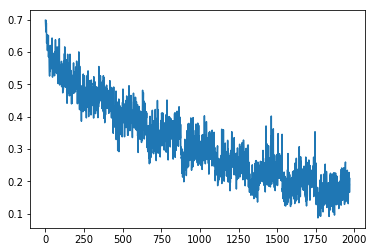

In [5]:
plt.plot(loss_c)

In [12]:
from matplotlib import pyplot as plt
params = {'batch_size': 256,
              'shuffle': True,
              'num_workers': 6}

dataFolder = './data'

df_ddi = pd.read_csv('../data/SNAP/sup_test.csv')  # ddi dataframe drug1_smiles, drug2_smiles
labels_sup = df_ddi.label.values
test_set = supData(df_ddi.index.values, labels_sup, df_ddi)
test_generator_sup = data.DataLoader(test_set, **params)

model_nn = model_max

y_pred = []
y_label = []
model_nn.eval()
for i, (v_D, label) in tqdm(enumerate(test_generator_sup)):
    recon, code, score, Z_f, z_D = model_nn(v_D.float())
    m = torch.nn.Sigmoid()
    logits = torch.squeeze(m(score)).detach().cpu().numpy()
    label_ids = label.to('cpu').numpy()
    y_label = y_label + label_ids.flatten().tolist()
    y_pred = y_pred + logits.flatten().tolist()

63it [13:01, 12.41s/it]


0.8941994440870269

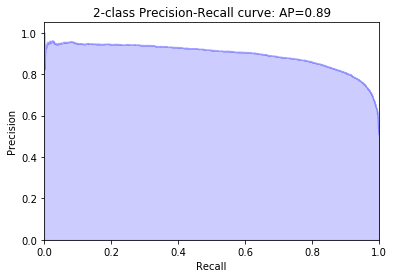

In [13]:
from sklearn.metrics import average_precision_score
average_precision_score(y_label, y_pred)
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
average_precision = average_precision_score(y_label, y_pred)
precision, recall, _ = precision_recall_curve(y_label, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
average_precision

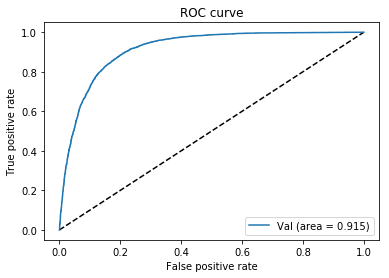

In [15]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report

fpr, tpr, thresholds = roc_curve(y_label, y_pred)
auc_score = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Val (area = {:.3f})'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

Author:  Kexin Huang, [CASTER Work](https://github.com/kexinhuang12345/CASTER)
Modifications:  Ryan Kather

@article{huang2019caster,
  title={CASTER: Predicting Drug Interactions with Chemical Substructure Representation},
  author={Huang, Kexin and Xiao, Cao and Hoang, Trong Nghia and Glass, Lucas M and Sun, Jimeng},
  journal={AAAI},
  year={2020}
}